In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from cm import plot_confusion_matrix

%matplotlib inline

### Reading in and examining the heart attack cost disparities data

In [46]:
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv') 
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


### Now examining the cancer data

In [47]:
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


### Getting the income data and cleaning it a bit

In [48]:
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.head(2)

,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,...,4300,9256,70,57,0,0,2590,3685,11510,35079
1,1,AL,0,Alabama,2,285760,217880,25170,39740,143390,...,70050,40569,0,0,0,0,22720,11109,237630,263152


In [49]:
income_df = income_df[['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']]
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']
income_df.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203
1,AL,Alabama,2,285760,217880,25170,39740,296830,78450,48270,1582247,285760,1632624,4180,10772


#### Creating a new df that aggregates by state and county to get the totals for each county

In [50]:
income_agg = income_df.groupby(['state','county']).agg('sum').reset_index()
income_agg.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460
1,AK,Aleutians East Borou,36,890,480,230,150,1570,500,160,42834,890,43596,190,466


In [51]:
income_agg['avg_income'] = round(income_agg.total_inc_amt * 1000 / income_agg.returns_with_total_inc, 0)

#### Week 4 Coding Tasks
 - rename `analysis_value` columns in `ha_costs_df` and `cancer_costs_df`
 

In [52]:
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [53]:
ha_costs_df = ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'})
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [54]:
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})
cancer_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


#### Create a new dataframe  `combined_df` 
- merge `county`, `urban`, and `ha_avg_cost` from `ha_costs_df` with `county` and `cancer_avg_cost` from `cancer_costs_df`


In [55]:
cancer_cost_sub = cancer_costs_df[['state', 'county', 'urban', 'cancer_avg_cost']]
ha_cost_sub = ha_costs_df[['state','county', 'ha_avg_cost']]

In [56]:
combined_df = pd.merge(cancer_cost_sub, ha_cost_sub, on = ['state', 'county'], how = 'inner')
print(combined_df.shape)
combined_df.head(2)

(2656, 5)


,state,county,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,Urban,19293,40470
1,ALABAMA,Baldwin County,Rural,17151,36615


#### Now combine all the data and create the cost_income_ratio variables

- merge `avg_income` from `income_agg` with `combined_df` and save back to the `combined_df` variable  

- create `ha_cost_income_ratio` (`ha_avg_cost` / `avg_income`)  

- create `cancer_cost_income_ratio` (`cancer_avg_cost` / `avg_income`)

In [57]:
county_incomes = income_agg[['state','county', 'avg_income']]
county_incomes.head(2)

,state,county,avg_income
0,AK,Alaska,68636.0
1,AK,Aleutians East Borou,48984.0


#### Before you can merge county incomes and combined_df, the data is the `state` columns will need to match

In [58]:
state_abbrev = pd.read_csv('../data/state_abbrev.csv')
state_abbrev.head(3)

,name,abbrev
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ


In [59]:
combined_df['state'] = combined_df.state.map(state_abbrev.set_index('name')['abbrev'].to_dict())
combined_df.head()

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,AL,Autauga County,Urban,19293,40470
1,AL,Baldwin County,Rural,17151,36615
2,AL,Barbour County,Rural,19469,46509
3,AL,Bibb County,Urban,17234,42949
4,AL,Blount County,Urban,20317,50067


In [60]:
combined_df = pd.merge(combined_df, county_incomes, on = ['state', 'county'], how = 'inner')
combined_df.head(2)

,state,county,urban,cancer_avg_cost,ha_avg_cost,avg_income
0,AL,Autauga County,Urban,19293,40470,55843.0
1,AL,Baldwin County,Rural,17151,36615,62832.0


#### What is our target variable? What are the predictor variables?
- The target is whether or not `cancer_avg_cost` is above or below the mean. 
- Predictors are `ha_avg_cost`, `urban`, and `avg_income`

In [61]:
combined_df['ha_cost_ratio'] = combined_df['ha_avg_cost'] / combined_df['avg_income']
combined_df['cancer_cost_ratio'] = combined_df['cancer_avg_cost'] / combined_df['avg_income']

In [62]:
combined_df.head()

,state,county,urban,cancer_avg_cost,ha_avg_cost,avg_income,ha_cost_ratio,cancer_cost_ratio
0,AL,Autauga County,Urban,19293,40470,55843.0,0.724710,0.345486
1,AL,Baldwin County,Rural,17151,36615,62832.0,0.582744,0.272966
2,AL,Barbour County,Rural,19469,46509,40269.0,1.154958,0.483474
3,AL,Bibb County,Urban,17234,42949,47380.0,0.906480,0.363740
4,AL,Blount County,Urban,20317,50067,49535.0,1.010740,0.410154


In [63]:
avg_cancer_ratio = combined_df.cancer_cost_ratio.mean()
avg_ha_ratio = combined_df.ha_cost_ratio.mean()

In [64]:
combined_df['above_avg_cancer_ratio'] = combined_df['cancer_cost_ratio'] > avg_cancer_ratio
combined_df['above_avg_ha_ratio'] = combined_df['ha_cost_ratio'] > avg_ha_ratio

In [65]:
combined_df.head()

,state,county,urban,cancer_avg_cost,ha_avg_cost,avg_income,ha_cost_ratio,cancer_cost_ratio,above_avg_cancer_ratio,above_avg_ha_ratio
0,AL,Autauga County,Urban,19293,40470,55843.0,0.724710,0.345486,False,False
1,AL,Baldwin County,Rural,17151,36615,62832.0,0.582744,0.272966,False,False
2,AL,Barbour County,Rural,19469,46509,40269.0,1.154958,0.483474,True,True
3,AL,Bibb County,Urban,17234,42949,47380.0,0.906480,0.363740,False,False
4,AL,Blount County,Urban,20317,50067,49535.0,1.010740,0.410154,True,True


In [66]:
combined_df = pd.get_dummies(combined_df, columns = ['urban'], drop_first = True)
combined_df.head(3)

,state,county,cancer_avg_cost,ha_avg_cost,avg_income,ha_cost_ratio,cancer_cost_ratio,above_avg_cancer_ratio,above_avg_ha_ratio,urban_Urban
0,AL,Autauga County,19293,40470,55843.0,0.724710,0.345486,False,False,1
1,AL,Baldwin County,17151,36615,62832.0,0.582744,0.272966,False,False,0
2,AL,Barbour County,19469,46509,40269.0,1.154958,0.483474,True,True,0


# Using only urban/rural to predict

In [67]:
X = combined_df[['urban_Urban']]
y = combined_df.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

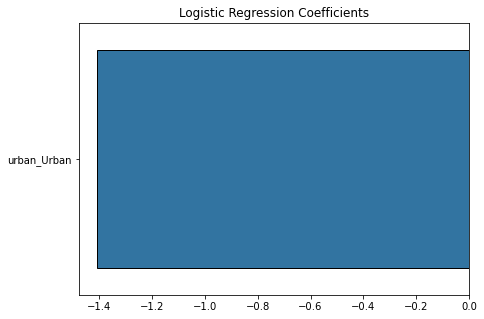

In [68]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

Looks like a county being urban decreases the chances that the cost ratio will be above average.

In [69]:
# Model using no predictors
y_test.value_counts(normalize = True)

False    0.519084
True     0.480916
Name: above_avg_cancer_ratio, dtype: float64

In [70]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6687022900763359


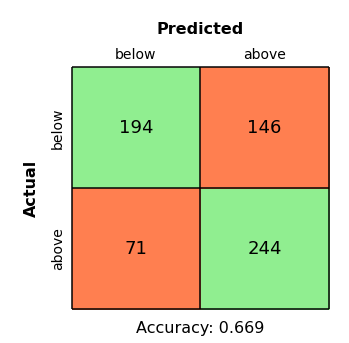

In [71]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

#### Our model is a bit better than the naive model

In [72]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.57      0.64       340
        True       0.63      0.77      0.69       315

    accuracy                           0.67       655
   macro avg       0.68      0.67      0.67       655
weighted avg       0.68      0.67      0.67       655



#### Let's check AUC

In [73]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

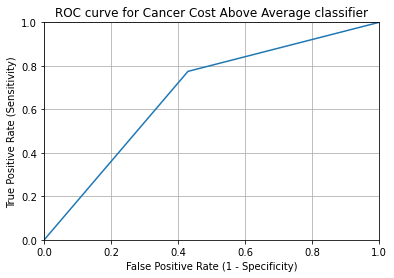

In [75]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

#### Incorporting some of the geographic profile data

In [76]:
geographic_info = pd.read_csv('../data/geographic_profile.csv')

In [77]:
geographic_info

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),...,Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,Alabama,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,...,0.101183,0.106110,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252
1,Alabama,Baldwin County,51365.0,86250.0,26010.0,59570.0,68369.0,79153.0,69484.0,67693.0,...,0.124101,0.129932,0.077699,0.069984,0.293833,0.274180,0.032243,0.037965,0.035886,0.062713
2,Alabama,Barbour County,33956.0,NaN,16450.0,42631.0,42429.0,44563.0,46563.0,48250.0,...,0.093651,0.226190,NaN,0.162366,NaN,0.221912,NaN,0.083538,NaN,0.128247
3,Alabama,Bibb County,39776.0,111477.0,19127.0,41183.0,43520.0,51760.0,68375.0,76579.0,...,0.110305,0.206096,NaN,0.106445,NaN,0.214445,NaN,0.036667,NaN,0.071429
4,Alabama,Blount County,46212.0,50723.0,22171.0,50601.0,60406.0,64705.0,54390.0,48913.0,...,0.043669,0.186762,NaN,0.098941,NaN,0.132788,NaN,0.049601,NaN,0.059515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,Wyoming,Sweetwater County,68233.0,94211.0,36884.0,77074.0,74030.0,89070.0,90544.0,103275.0,...,0.136929,0.053565,NaN,0.089024,NaN,0.125851,NaN,0.031863,NaN,0.050685
3216,Wyoming,Teton County,75594.0,NaN,40613.0,86401.0,104185.0,106379.0,102321.0,78681.0,...,0.285209,0.000000,NaN,0.046450,NaN,0.344267,NaN,0.027027,NaN,0.021234
3217,Wyoming,Uinta County,53323.0,78750.0,26641.0,59345.0,56186.0,79000.0,55822.0,125663.0,...,0.054170,0.075666,NaN,0.097962,NaN,0.150205,NaN,0.101167,NaN,0.063908
3218,Wyoming,Washakie County,46212.0,63250.0,25625.0,61114.0,66894.0,61667.0,42500.0,NaN,...,0.153680,0.064935,NaN,0.044981,NaN,0.081868,NaN,0.041262,NaN,0.074419


Getting the correct formatting on the state column.

In [78]:
geographic_info['state'] = geographic_info.state.str.upper().str.strip().map(state_abbrev.set_index('name')['abbrev'].to_dict())

Checking for missing values and seeing what columns are available.

In [79]:
geographic_info.isna().sum()

state                                                                    0
county                                                                   0
Median Household Income (5y Average)                                     0
Median Household Income for +7-person Households (5y Avg.)             777
Median Household Income for 1-person Households (5y Avg.)                0
Median Household Income for 2-person Households (5y Avg.)                1
Median Household Income for 3-person Households (5y Avg.)               19
Median Household Income for 4-person Households (5y Avg.)               39
Median Household Income for 5-person Households (5y Avg.)              125
Median Household Income for 6-person Households (5y Avg.)              455
Percent Below Federal Poverty Level (1y Avg.)                         2389
Percent Below Federal Poverty Level (5y Avg.)                            0
Percent of +4 Person Households with +3 Workers (5y Avg.)                0
Percent of +4 Person Hous

Grabbing the usable predictors. Note that I did not use Median Household Income.

In [80]:
geographic_info = geographic_info[['state', 'county', 'Percent Below Federal Poverty Level (5y Avg.)',
                 'Percent of Senior Population Below Federal Poverty Level (5y Avg.)', 'Unemployment Rate (5y Avg.)']]

In [81]:
combined_df = combined_df[['state', 'county', 'above_avg_cancer_ratio', 'above_avg_ha_ratio', 'urban_Urban']]

In [83]:
combined_df = pd.merge(left = combined_df, right = geographic_info)

In [85]:
X = combined_df.drop(columns = ['state', 'county', 'above_avg_cancer_ratio', 'above_avg_ha_ratio'])
y = combined_df.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

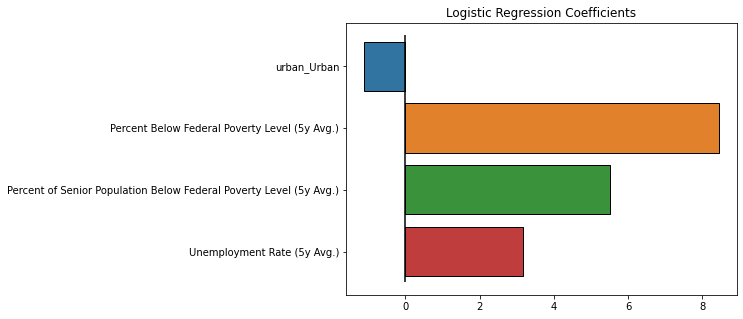

In [88]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

In [89]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7404580152671756


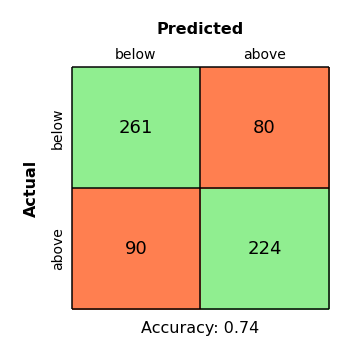

In [90]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [91]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8273156882156266


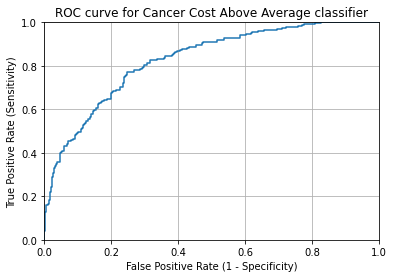

In [92]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Adding States

In [93]:
combined_df_dummy = pd.get_dummies(combined_df, columns = ['state'])

In [94]:
X = combined_df_dummy.drop(columns = ['county', 'above_avg_cancer_ratio', 'above_avg_ha_ratio'])
y = combined_df_dummy.above_avg_cancer_ratio

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

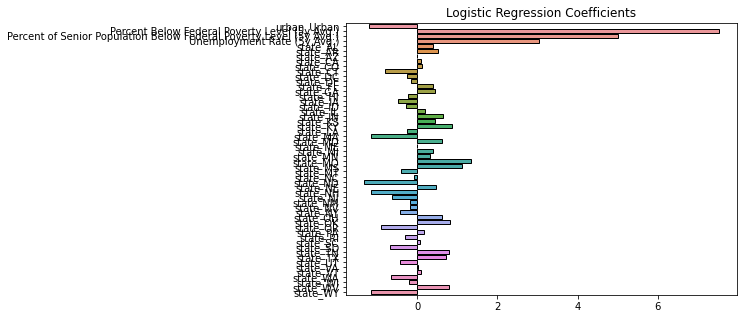

In [96]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

In [97]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7572519083969466


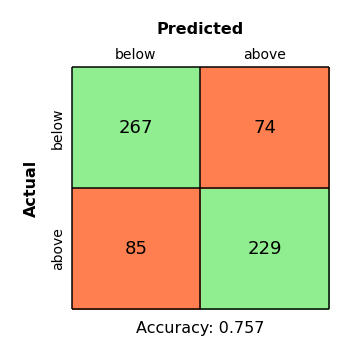

In [98]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [99]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8306311522872032


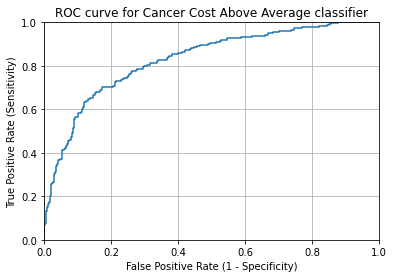

In [100]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Adding the Health Outcomes Data

In [102]:
health_rankings = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 1, header = (1))

In [103]:
health_rankings = health_rankings.rename(columns = {'Rank': 'Outcomes_Rank',
                                 'Quartile': 'Outcomes_Quartile',
                                 'Rank.1': 'Factors_Rank',
                                 'Quartile.1': 'Factors_Quartile'})

Normalizing the rank by dividing by the number of rankings in the state + 1.

In [109]:
for col in ['Outcomes_Rank', 'Factors_Rank']:
    health_rankings[col] = pd.to_numeric(health_rankings[col], errors = 'coerce')
    health_rankings['Normalized_{}'.format(col.split('_')[0])] = 1 - health_rankings[col] / (health_rankings['# of Ranked Counties'] + 1)

<ipython-input-109-95346b6cb1ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_rankings[col] = pd.to_numeric(health_rankings[col], errors = 'coerce')
<ipython-input-109-95346b6cb1ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_rankings['Normalized_{}'.format(col.split('_')[0])] = 1 - health_rankings[col] / (health_rankings['# of Ranked Counties'] + 1)


In [110]:
health_rankings

,FIPS,State,County,# of Ranked Counties,Outcomes_Rank,Outcomes_Quartile,Factors_Rank,Factors_Quartile,Normalized_Outcomes,Normalized_Factors,state,county
0,1001,Alabama,Autauga,67,11.0,1,8.0,1,0.838235,0.882353,AL,Autauga County
1,1003,Alabama,Baldwin,67,3.0,1,3.0,1,0.955882,0.955882,AL,Baldwin County
2,1005,Alabama,Barbour,67,34.0,2,56.0,4,0.500000,0.176471,AL,Barbour County
3,1007,Alabama,Bibb,67,41.0,3,37.0,3,0.397059,0.455882,AL,Bibb County
4,1009,Alabama,Blount,67,14.0,1,19.0,2,0.794118,0.720588,AL,Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,Sweetwater,23,15.0,3,21.0,4,0.375000,0.125000,WY,Sweetwater County
3138,56039,Wyoming,Teton,23,1.0,1,1.0,1,0.958333,0.958333,WY,Teton County
3139,56041,Wyoming,Uinta,23,21.0,4,17.0,3,0.125000,0.291667,WY,Uinta County
3140,56043,Wyoming,Washakie,23,8.0,2,15.0,3,0.666667,0.375000,WY,Washakie County


In [111]:
health_rankings = health_rankings.dropna(subset = ['Normalized_Outcomes', 'Normalized_Factors'])

In [112]:
health_rankings['state'] = health_rankings.State.str.upper().str.strip().map(state_abbrev.set_index('name')['abbrev'].to_dict())

In [113]:
health_rankings['county'] = health_rankings['County'] + ' County'

In [114]:
combined_df = pd.merge(left = combined_df, right = health_rankings[['state', 'county', 'Normalized_Outcomes', 'Normalized_Factors']])

In [115]:
combined_df_dummy = pd.get_dummies(combined_df, columns = ['state'])
X = combined_df_dummy.drop(columns = ['county', 'above_avg_cancer_ratio', 'above_avg_ha_ratio'])
y = combined_df_dummy.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [116]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8003169572107766


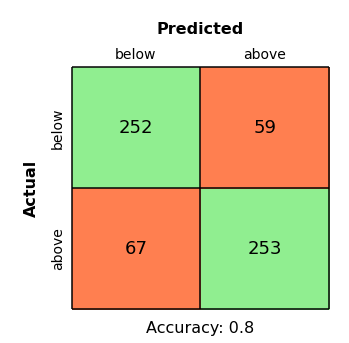

In [117]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [118]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8743971061093248


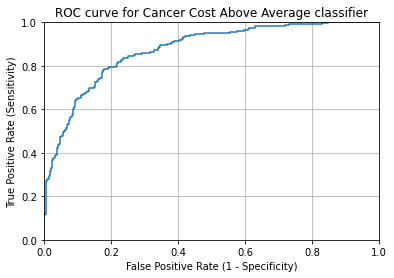

In [119]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)